In [1]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html

    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels

    # Not sure why, but yann lecun's website does no longer support
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'

    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)

    return train_features, train_labels, test_features, test_labels

Done.
Done.
Done.
Done.
Epoch 1 | 0/60000 Loss/sample: 549.5739
Epoch 1 | 12800/60000 Loss/sample: 179.3973
Epoch 1 | 25600/60000 Loss/sample: 160.3232
Epoch 1 | 38400/60000 Loss/sample: 139.9454
Epoch 1 | 51200/60000 Loss/sample: 137.0203
[Train] Epoch 1 - avg Loss: 162.6857 | BCE: 146.7369 | KL: 15.9488
[Test ] Epoch 1 - avg Loss: 128.8769 | BCE: 106.2950 | KL: 22.5818
Epoch 2 | 0/60000 Loss/sample: 130.5891
Epoch 2 | 12800/60000 Loss/sample: 121.6951
Epoch 2 | 25600/60000 Loss/sample: 123.7571
Epoch 2 | 38400/60000 Loss/sample: 120.4309
Epoch 2 | 51200/60000 Loss/sample: 115.6537
[Train] Epoch 2 - avg Loss: 122.4872 | BCE: 99.0211 | KL: 23.4660
[Test ] Epoch 2 - avg Loss: 116.5504 | BCE: 92.2834 | KL: 24.2670
Epoch 3 | 0/60000 Loss/sample: 119.5572
Epoch 3 | 12800/60000 Loss/sample: 111.9704
Epoch 3 | 25600/60000 Loss/sample: 116.0371
Epoch 3 | 38400/60000 Loss/sample: 116.7814
Epoch 3 | 51200/60000 Loss/sample: 111.7031
[Train] Epoch 3 - avg Loss: 114.8614 | BCE: 89.7165 | KL: 25.1

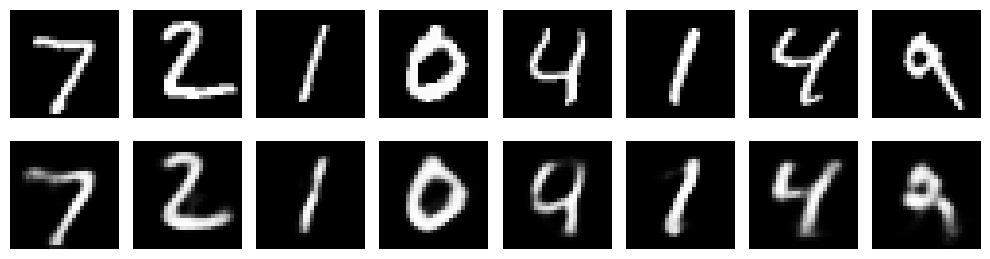

In [2]:
# —— get_mnist() 已經在上方定義好 —— #
# 直接取資料
train_features, train_labels, test_features, test_labels = get_mnist()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 1. 轉 tensor 建立 DataLoader（label 不會用到）
train_x = torch.tensor(train_features, dtype=torch.float32)
test_x  = torch.tensor(test_features, dtype=torch.float32)
train_dataset = TensorDataset(train_x, train_x)
test_dataset  = TensorDataset(test_x, test_x)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 2. VAE 模型
class VAE(nn.Module):
    def __init__(self, z_dim=20, h_dim=400):
        super().__init__()
        self.fc1  = nn.Linear(28 * 28, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)  # mu
        self.fc22 = nn.Linear(h_dim, z_dim)  # logvar
        self.fc3  = nn.Linear(z_dim, h_dim)
        self.fc4  = nn.Linear(h_dim, 28 * 28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # 配合 BCE 使用 sigmoid

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    x = x.view(-1, 28 * 28)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KL  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL, BCE, KL

# 3. 裝置、隨機種子、模型與優化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
model = VAE(z_dim=32, h_dim=512).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. 訓練與測試
def train_epoch(epoch):
    model.train()
    total, total_bce, total_kl = 0.0, 0.0, 0.0

    for b, (x, _) in enumerate(train_loader):
        # 批次讀資料，搬到 CPU/GPU
        x = x.to(device)
        # 清掉上一步的梯度，避免累加污染
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss, bce, kl = vae_loss(recon_x=x_hat, x=x, mu=mu, logvar=logvar)

        # 反傳、更新參數
        loss.backward()
        optimizer.step()
        total += loss.item()
        total_bce += bce.item()
        total_kl += kl.item()

        if b % 100 == 0:
            print(f"Epoch {epoch} | {b*len(x)}/{len(train_loader.dataset)} "
                  f"Loss/sample: {loss.item()/len(x):.4f}")

    N = len(train_loader.dataset)
    print(f"[Train] Epoch {epoch} - avg Loss: {total/N:.4f} | BCE: {total_bce/N:.4f} | KL: {total_kl/N:.4f}")

@torch.no_grad()
def evaluate(epoch):
    model.eval()
    total, total_bce, total_kl = 0.0, 0.0, 0.0

    for x, _ in test_loader:
        x = x.to(device)

        x_hat, mu, logvar = model(x)
        loss, bce, kl = vae_loss(recon_x=x_hat, x=x, mu=mu, logvar=logvar)

        total += loss.item()
        total_bce += bce.item()
        total_kl += kl.item()

    N = len(test_loader.dataset)
    print(f"[Test ] Epoch {epoch} - avg Loss: {total/N:.4f} | BCE: {total_bce/N:.4f} | KL: {total_kl/N:.4f}")

@torch.no_grad()
def save_reconstruction(n=8):
    model.eval()

    # 視覺化
    x_vis, _ = next(iter(test_loader))
    x_vis = x_vis.to(device)
    x_hat, _, _ = model(x_vis)

    imgs = x_vis[:n].cpu().numpy()
    recons = x_hat[:n].view(-1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, n, figsize=(10, 3))
    for i in range(n):
        axes[0, i].imshow(imgs[i], cmap="gray");   axes[0, i].axis("off")
        axes[1, i].imshow(recons[i], cmap="gray"); axes[1, i].axis("off")
    plt.tight_layout()

    # 檔名
    save_path = f"reconstruction.png"
    plt.savefig(save_path, dpi=150)
    # plt.close(fig)
    print(f"已儲存重建圖檔 {save_path}")

# 5. Execute
epochs = 5
for ep in range(1, epochs+1):
    train_epoch(ep)
    evaluate(ep)

print("訓練完成！")
save_reconstruction()

